In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf

from edward.models import Gamma, Normal
import matplotlib.pyplot as plt

rs = np.random.RandomState(0)
ed.set_seed(42)
% matplotlib inline
% config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['font.size'] = 6
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'

tf.flags.DEFINE_integer("N", 40, "Number of data points.")
tf.flags.DEFINE_integer("D", 1, "Number of features.")
tf.flags.DEFINE_string("WIDTH", "20-10-1", "Number of neuron per layer.")

FLAGS = tf.flags.FLAGS

/home/disij/.local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def build_toy_dataset(N=40, noise_std=0.1):
    D = 1
    X = np.concatenate([np.linspace(0, 2, num=N / 2),
                      np.linspace(6, 8, num=N / 2)])
    y = np.cos(X) + np.random.normal(0, noise_std, size=N)
    X = (X - 4.0)
    X = X.reshape((N, D))
    return X, y

def display_draws(x_data, y_data, draw_inputs, draw_outputs, label):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_data, y_data, 'ks', alpha=0.5, label='(x, y)')
    ax.plot(draw_inputs, draw_outputs[0].T, 'r', lw=2, alpha=0.5, label=label)
    ax.plot(draw_inputs, draw_outputs[1:].T, 'r', lw=2, alpha=0.5)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-2, 3])
    ax.legend()
    plt.show()
    
def neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2):
    h = tf.tanh(tf.matmul(X, W_0) + b_0)
    h = tf.tanh(tf.matmul(h, W_1) + b_1)
    h = tf.matmul(h, W_2) + b_2
    return tf.reshape(h, [-1])

In [3]:
# DATA
X_train, y_train = build_toy_dataset(FLAGS.N)

# MODEL
with tf.name_scope("model"):
    WIDTH = [int(_) for _ in FLAGS.WIDTH.split("-")]
    W_0 = Gamma(concentration=tf.ones([FLAGS.D, WIDTH[0]]),
                rate=tf.ones([FLAGS.D, WIDTH[0]]), name="W_0")
    W_1 = Gamma(concentration=tf.ones([WIDTH[0], WIDTH[1]]), 
                rate=tf.ones([WIDTH[0], WIDTH[1]]), name="W_1")
    W_2 = Gamma(concentration=tf.ones([WIDTH[1], WIDTH[2]]), 
                rate=tf.ones([WIDTH[1], WIDTH[2]]), name="W_2")
    b_0 = Gamma(concentration=tf.ones(WIDTH[0]), 
                rate=tf.ones(WIDTH[0]), name="b_0")
    b_1 = Gamma(concentration=tf.ones(WIDTH[1]), 
                rate=tf.ones(WIDTH[1]), name="b_1")
    b_2 = Gamma(concentration=tf.ones(WIDTH[2]), 
                rate=tf.ones(WIDTH[2]), name="b_2")
    X = tf.placeholder(tf.float32, [FLAGS.N, FLAGS.D], name="X")
    y = Normal(loc=neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2), 
               scale=0.1 * tf.ones(FLAGS.N), name="y")

# INFERENCE
with tf.variable_scope("posterior"):
    with tf.variable_scope("qW_0"):
        concentration = tf.nn.softplus(tf.get_variable("concentration", [FLAGS.D, WIDTH[0]]))
        rate = tf.nn.softplus(tf.get_variable("rate", [FLAGS.D, WIDTH[0]]))
        qW_0 = Gamma(concentration=concentration, rate=rate)
    with tf.variable_scope("qW_1"):
        concentration = tf.nn.softplus(tf.get_variable("concentration", [WIDTH[0], WIDTH[1]]))
        rate = tf.nn.softplus(tf.get_variable("rate", [WIDTH[0], WIDTH[1]]))
        qW_1 = Gamma(concentration=concentration, rate=rate)
    with tf.variable_scope("qW_2"):
        concentration = tf.nn.softplus(tf.get_variable("concentration", [WIDTH[1], WIDTH[2]]))
        rate = tf.nn.softplus(tf.get_variable("rate", [WIDTH[1], WIDTH[2]]))
        qW_2 = Gamma(concentration=concentration, rate=rate)
    with tf.variable_scope("qb_0"):
        concentration = tf.nn.softplus(tf.get_variable("concentration", [WIDTH[0]]))
        rate = tf.nn.softplus(tf.get_variable("rate", [WIDTH[0]]))
        qb_0 = Gamma(concentration=concentration, rate=rate)
    with tf.variable_scope("qb_1"):
        concentration = tf.nn.softplus(tf.get_variable("concentration", [WIDTH[1]]))
        rate = tf.nn.softplus(tf.get_variable("rate", [WIDTH[1]]))
        qb_1 = Gamma(concentration=concentration, rate=rate)
    with tf.variable_scope("qb_2"):
        concentration = tf.nn.softplus(tf.get_variable("concentration", [WIDTH[2]]))
        rate = tf.nn.softplus(tf.get_variable("rate", [WIDTH[2]]))
        qb_2 = Gamma(concentration=concentration, rate=rate)

/home/disij/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()
/home/disij/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


In [4]:
# Sample neural networks from our variational model.
inputs = np.linspace(-5, 5, num=500, dtype=np.float32)
nx = tf.expand_dims(inputs, 1)
mus = tf.stack([neural_network(nx, qW_0.sample(), qW_1.sample(), qW_2.sample(),
                               qb_0.sample(), qb_1.sample(), qb_2.sample()) 
                for _ in range(5)])

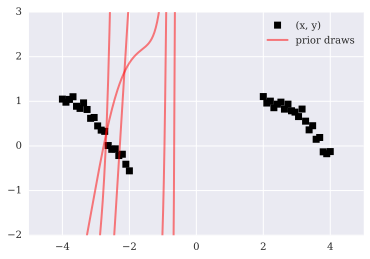

In [5]:
##### VISUALIZE  SAMPLES FROM PRIOR
sess = ed.get_session()
tf.global_variables_initializer().run()
display_draws(X_train, y_train, inputs, mus.eval(), 'prior draws')

In [6]:
tf.contrib.distributions.kl = tf.contrib.distributions.kl_divergence
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1,
                     W_2: qW_2, b_2: qb_2}, 
                     data={X: X_train, y: y_train})
inference.run(n_iter=10000, logdir='log')

/home/disij/.local/lib/python2.7/site-packages/edward/util/random_variables.py:48: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


10000/10000 [100%] ██████████████████████████████ Elapsed: 11s | Loss: 1636.688


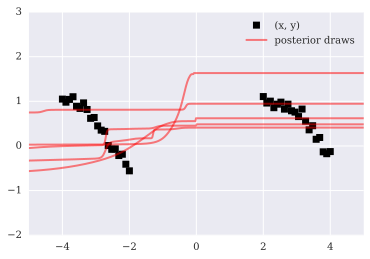

In [7]:
##### VISUALIZE  SAMPLES FROM POSTERIOR
display_draws(X_train, y_train, inputs, mus.eval(), 'posterior draws')